In [120]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from ast import literal_eval
from random import randint
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

In [121]:
# Load the data
data = pd.read_csv('pose-coordinates/combined_exercise_data.csv')

In [122]:
# List of body parts
body_parts = ['left_hip', 'left_knee', 'left_ankle', 'left_shoulder', 'left_elbow', 'left_wrist', 
              'right_hip', 'right_knee', 'right_ankle', 'right_shoulder', 'right_elbow', 'right_wrist']

# Convert the string representation of list to actual list for each body part
for body_part in body_parts:
    data[body_part] = data[body_part].apply(literal_eval)

# Split the coordinates into separate columns
for body_part in body_parts:
    data[[f'{body_part}_x', f'{body_part}_y', f'{body_part}_z']] = pd.DataFrame(data[body_part].to_list(), index= data.index)

# Drop the original columns
data.drop(body_parts, axis=1, inplace=True)

In [123]:
# Convert the labels to numeric form
le = LabelEncoder()
data['exercise'] = le.fit_transform(data['exercise'])
print(le.classes_)

['lunge' 'push-up' 'squat']


In [124]:
# Number of videos and list to store indices of videos with missing frames
n_samples = len(data) // 75
missing_videos = []

# Check each video for missing frames
for i in range(n_samples):
    start_index = i * 75
    end_index = start_index + 75
    if end_index > len(data):
        end_index = len(data)
    video_data = data.iloc[start_index:end_index]
    
    if len(video_data) < 75:
        missing_videos.append(i)
        continue

# Handle videos with missing frames
for i in missing_videos:
    start_index = i * 75
    end_index = start_index + 75
    if end_index > len(data):
        end_index = len(data)
    video_data = data.iloc[start_index:end_index]
    
    # Find the missing frame indices
    missing_indices = []
    for j in range(start_index, end_index):
        if pd.isnull(data.iloc[j]).any():
            missing_indices.append(j)
    
    # Handle each missing frame
    for missing_index in missing_indices:
        # Fit a linear regression model using the preceding and succeeding frames
        model = LinearRegression()
        if missing_index == start_index:  # if the missing frame is the first frame
            X_train = np.array([missing_index + 1, missing_index + 2]).reshape(-1, 1)
            y_train = data.iloc[[missing_index + 1, missing_index + 2]]
        elif missing_index == end_index - 1:  # if the missing frame is the last frame
            X_train = np.array([missing_index - 1, missing_index - 2]).reshape(-1, 1)
            y_train = data.iloc[[missing_index - 1, missing_index - 2]]
        else:  # if the missing frame is in between
            X_train = np.array([missing_index - 1, missing_index + 1]).reshape(-1, 1)
            y_train = data.iloc[[missing_index - 1, missing_index + 1]]
        
        # Drop the 'exercise' column since it's not used for prediction
        y_train = y_train.drop('exercise', axis=1)
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict the missing frame
        y_pred = model.predict(np.array(missing_index).reshape(-1, 1))
        
        # Replace the missing frame in the original data with the predicted frame
        data.iloc[missing_index] = np.append(y_pred.flatten(), video_data['exercise'].mode()[0])

# Reshape the data and split it into training and test sets
n_samples = len(data) // 75
n_time_steps = 75
n_features = len(body_parts) * 3
X = []
y = []

# Iterate over each video
for i in range(n_samples):
    start_index = i * 75
    end_index = start_index + 75
    if end_index > len(data):
        end_index = len(data)
    video_data = data.iloc[start_index:end_index]
    
    # Only use complete videos
    if len(video_data) == 75:
        X_video = video_data.drop(['frame_time', 'exercise'], axis=1).to_numpy().reshape(1, n_time_steps, n_features)
        y_video = np.array([video_data['exercise'].iloc[0]])  # Only select the first label of each video
        X.append(X_video)
        y.append(y_video)

# Convert the lists to numpy arrays
X = np.concatenate(X)
y = np.concatenate(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=randint(1,100))


In [125]:
# Check if GPU is available and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)  # Change dtype to long
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)  # Change dtype to long


class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.batchnorm(out[:, -1, :])
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Define the model with 3 output neurons
model = LSTMModel(n_features, 32, 3, 2, 0.2).to(device)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Change loss function to CrossEntropyLoss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 200
train_losses = []
validation_losses = []  # a list to save validation/test loss


for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    # Evaluate the model
    model.eval()

    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        validation_loss = criterion(val_outputs, y_test_tensor)
        validation_losses.append(validation_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss.item()}, Validation Loss: {validation_loss.item()}')


with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    # Apply argmax to the predictions
    y_test_pred = torch.argmax(y_test_pred, dim=1)

Epoch 0, Train Loss: 1.1025209426879883, Validation Loss: 1.0362012386322021
Epoch 10, Train Loss: 0.694324791431427, Validation Loss: 1.0384318828582764
Epoch 20, Train Loss: 0.527703583240509, Validation Loss: 0.952177107334137
Epoch 30, Train Loss: 0.37874454259872437, Validation Loss: 0.7529922127723694
Epoch 40, Train Loss: 0.2569434940814972, Validation Loss: 0.4953097403049469
Epoch 50, Train Loss: 0.1623513400554657, Validation Loss: 0.3116070330142975
Epoch 60, Train Loss: 0.07578421384096146, Validation Loss: 0.1732262223958969
Epoch 70, Train Loss: 0.04176614060997963, Validation Loss: 0.07128170877695084
Epoch 80, Train Loss: 0.034468021243810654, Validation Loss: 0.05261025205254555
Epoch 90, Train Loss: 0.014884722419083118, Validation Loss: 0.039617571979761124
Epoch 100, Train Loss: 0.013586671091616154, Validation Loss: 0.012709681876003742
Epoch 110, Train Loss: 0.009971187449991703, Validation Loss: 0.019027136266231537
Epoch 120, Train Loss: 0.011986881494522095, Va

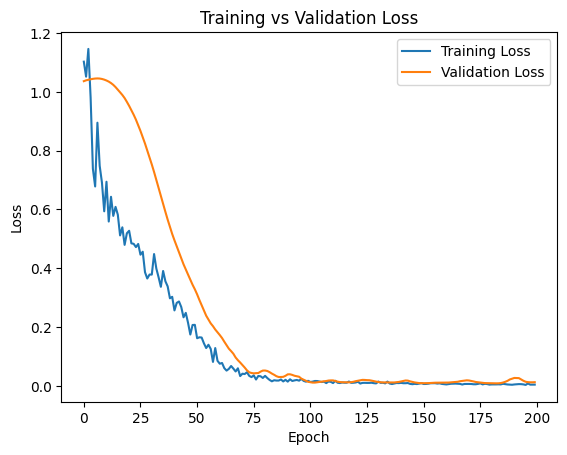

In [126]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [127]:
# Calculate accuracy
accuracy = (y_test_pred == y_test_tensor).sum().item() / len(y_test_tensor)
print('Accuracy: %', accuracy * 100)

Accuracy: % 100.0


In [128]:
# Save the model
torch.save(model.state_dict(), 'exercise_classification_model.pth')